In [1]:
import numpy as np
import cv2
import pandas as pd
from scipy import ndimage as nd
 
import pickle
from matplotlib import pyplot as plt
import os
from skimage.io import imread, imshow
from skimage.filters import roberts, sobel, scharr, prewitt
import glob

In [31]:
source_paths1 = "S2Hand/"
label_path = "LabelHand/"

sources = []
label = []

for file in os.listdir(source_paths1):
    if file.endswith("tif"):
      sources.append(file)
        
for file in os.listdir(label_path):
    if file.endswith("tif"):
      label.append(file)


## SAnity Check
sources = sorted(sources)
label = sorted(label)
print(len(sources))
print(len(label))

577
577


In [4]:
####################################################################
## STEP 1:   READ TRAINING IMAGES AND EXTRACT FEATURES - Sentinel 2
################################################################
image_dataset_s2 = pd.DataFrame()  #Dataframe to capture image features

img_path = "S2Hand/" # CHANGE ME!!!
for image in sources: #os.listdir(img_path):
    df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
    #Reset dataframe to blank after each loop.

    blue = imread(img_path + image)[0:1,:,:].reshape((128,128))    
    green = imread(img_path + image)[1:2,:,:].reshape((128,128))
    red = imread(img_path + image)[2:3,:,:].reshape((128,128))
    nir = imread(img_path + image)[3:4,:,:].reshape((128,128))
    swir = imread(img_path + image)[4:5,:,:].reshape((128,128))
    
    # Sentinel-2 MNDWI = (B03 - B08) / (B03 + B08)
    ndwi = (green - swir)/ (green + swir)
    ndwi_values = ndwi.reshape(-1)
    df['NDWI'] = ndwi_values  

    # Sentinel 2 NDVI = (NIR - RED) / (NIR + RED), where RED is B4 and NIR is B8
    ndvi = (nir - red)/ (red + nir)
    ndvi_values = ndvi.reshape(-1)
    df['NDVI'] = ndvi_values 

    #MEDIAN with sigma=3
    median_img = nd.median_filter(nir, size=3)
    median_img1 = median_img.reshape(-1)
    df['Median_s3'] = median_img1

   #VARIANCE with size=3
    variance_img = nd.generic_filter(nir, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance_s3'] = variance_img1  

   #ROBERTS EDGE
    edge_roberts = roberts(nir)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

    blue_values = blue.reshape(-1)
    df['Blue'] = blue_values  
            
    green_values = green.reshape(-1)
    df['Green'] = green_values   
             
        
    image_dataset_s2 = image_dataset_s2.append(df)  

In [5]:
###########################################################
# STEP 2: READ LABELED IMAGES (MASKS) AND CREATE ANOTHER DATAFRAME
    # WITH LABEL VALUES AND LABEL FILE NAMES
##########################################################
mask_dataset = pd.DataFrame()  #Create dataframe to capture mask info.

mask_path = "LabelHand/" ### CHANGE ME!!!
for mask in label:   #os.listdir(mask_path):
    df2 = pd.DataFrame()  #Temporary dataframe to capture info for each mask in the loop
    input_mask = imread(mask_path + mask)
    label = input_mask
    #Add pixel values to the data frame
    label_values = label.reshape(-1)
    df2['Label_Value'] = label_values
    df2['Mask_Name'] = mask
    mask_dataset = mask_dataset.append(df2)  #Update mask dataframe with all the info from each mask

In [6]:
################################################################
 #  STEP 3: GET DATA READY FOR RANDOM FOREST (or other classifier)
 # COMBINE BOTH DATAFRAMES INTO A SINGLE DATASET
###############################################################
dataset = pd.concat([image_dataset_s2, mask_dataset], axis=1)    #Concatenate both image and mask datasets

#If you expect image and mask names to be the same this is where we can perform sanity check
#dataset['Image_Name'].equals(dataset['Mask_Name'])   
##
##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
# dataset.fillna(-1, inplace=True)
dataset.fillna(999, inplace=True)
# dataset = dataset[dataset.Label_Value != -1]
dataset.dropna()
# dataset = dataset.reset_index()


#Assign training features to X and labels to Y
#Drop columns that are not relevant for training (non-features)
X = dataset.drop(labels = ["Mask_Name","Label_Value"], axis=1) 

#Assign label values to Y (our prediction)
Y = dataset["Label_Value"].values 

In [7]:
## Sanity Check
print(X.shape)
print(Y.shape)

(9453568, 7)
(9453568,)


In [8]:
################################################################
 #  STEP : Scale The Features
###############################################################
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [9]:
## Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3) #random_state=20

In [10]:
####################################################################
# STEP 4: Define the classifier and fit a model with our training data
###################################################################

#Import training classifier
from sklearn.ensemble import RandomForestClassifier
## Instantiate model with n number of decision trees
model = RandomForestClassifier(n_estimators = 20, verbose=10)

## Train the model on training data
model.fit(X_scaled, Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.3s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s


building tree 4 of 20


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.6min remaining:    0.0s


building tree 5 of 20


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.2min remaining:    0.0s


building tree 6 of 20


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.9min remaining:    0.0s


building tree 7 of 20


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.6min remaining:    0.0s


building tree 8 of 20


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.2min remaining:    0.0s


building tree 9 of 20


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.9min remaining:    0.0s


building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.9min finished


RandomForestClassifier(n_estimators=20, verbose=10)

In [ ]:
#######################################################
# STEP 5: Accuracy check
#########################################################

from sklearn import metrics
prediction_test = model.predict(X_scaled)
##Check accuracy on test dataset. 
print ("Accuracy = ", metrics.accuracy_score(Y, prediction_test))
print("IOU = ", metrics.jaccard_score(Y, prediction_test, average='micro'))
print("Precision = ", metrics.precision_score(Y, prediction_test,average='micro'))
print("Recall = ", 	metrics.recall_score(Y, prediction_test,average='micro'))
print("F1 score = ", metrics.f1_score(Y, prediction_test,average='micro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.1min finished


Accuracy =  0.9987306379982669
IOU =  0.9974644944709076
Precision =  0.9987306379982669
Recall =  0.9987306379982669
F1 score =  0.9987306379982669


Text(0.5, 0, 'Random Forest Feature Importance')

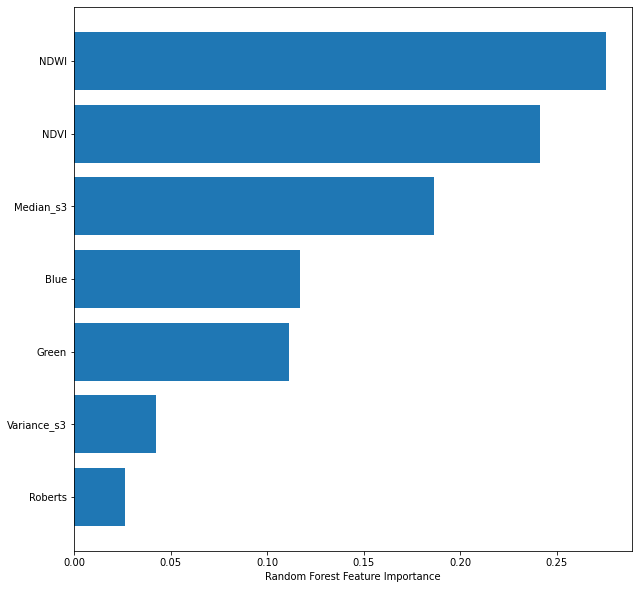

In [ ]:
### Feature Importance ####
# model.feature_importances_

# plt.barh(image_dataset.columns, model.feature_importances_)
fig=plt.figure(figsize=(10,10))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.margins(x=0, y=-0.10) 
plt.xlabel("Random Forest Feature Importance")

In [ ]:
##########################################################
#STEP 6: SAVE MODEL FOR FUTURE USE
###########################################################
##You can store the model for future use. In fact, this is how you do machine elarning
##Train on training images, validate on test images and deploy the model on unknown images. 
#
#
##Save the trained model as pickle string to disk for future use
model_name = "RF_S1Hand"
pickle.dump(model, open(model_name, 'wb'))
#
##To test the model on future datasets
#loaded_model = pickle.load(open(model_name, 'rb'))

Classification Map - Visual Validation

In [33]:
def feature_extraction(imge):
  img_path = "S2Hand/"

  df = pd.DataFrame()  #Temporary data frame to capture information for each loop.

  blue = imread(img_path + imge)[0:1,:,:].reshape((128,128))    
  green = imread(img_path + imge)[1:2,:,:].reshape((128,128))
  red = imread(img_path + imge)[2:3,:,:].reshape((128,128))
  nir = imread(img_path + imge)[3:4,:,:].reshape((128,128))
  swir = imread(img_path + imge)[4:5,:,:].reshape((128,128))
    
    # Sentinel-2 MNDWI = (B03 - B08) / (B03 + B08)
  ndwi = (green - swir)/ (green + swir)
  ndwi_values = ndwi.reshape(-1)
  df['NDWI'] = ndwi_values  

    # Sentinel 2 NDVI = (NIR - RED) / (NIR + RED), where RED is B4 and NIR is B8
  ndvi = (nir - red)/ (red + nir)
  ndvi_values = ndvi.reshape(-1)
  df['NDVI'] = ndvi_values 

    #MEDIAN with sigma=3
  median_img = nd.median_filter(nir, size=3)
  median_img1 = median_img.reshape(-1)
  df['Median_s3'] = median_img1

   #VARIANCE with size=3
  variance_img = nd.generic_filter(nir, np.var, size=3)
  variance_img1 = variance_img.reshape(-1)
  df['Variance_s3'] = variance_img1  

   #ROBERTS EDGE
  edge_roberts = roberts(nir)
  edge_roberts1 = edge_roberts.reshape(-1)
  df['Roberts'] = edge_roberts1

  blue_values = blue.reshape(-1)
  df['Blue'] = blue_values  
            
  green_values = green.reshape(-1)
  df['Green'] = green_values   

  return df

Bolivia_129334_S2Hand_00128128.tif


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


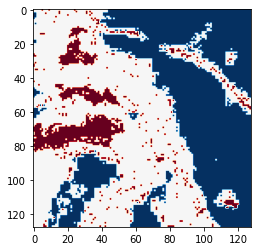

In [66]:
# Plot a predicted sample image
img1 = sources[1]
print(img1)
Ximg = feature_extraction(img1)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(Ximg)
X_scaled2 = scaler.transform(Ximg)
result = model.predict(X_scaled2)

segmented = result.reshape((128,128))
plt.imshow(segmented, cmap='RdBu')

Bolivia_129334_LabelHand_00128128.tif


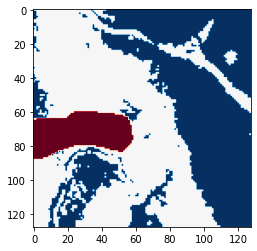

In [67]:
# Plot the Ground Truth Image
label1 = label[1]
print(label1)
mask_path = "LabelHand/"
input_mask = imread(mask_path + label1)
plt.imshow(input_mask, cmap='RdBu')